# Connectomes Data and Modeling Techniques

### Techniques covered in this Notebook
- Preprocessing the functional connectome data
- Graph Convolutional Neural Network

![image.png](attachment:38423bfa-a0fc-4e7c-93b7-b348595a47d0.png)

## Functional Connectomes

A **functional connectome** refers to the theoretical concept of the brain's functional connections, which describes how different brain regions interact and communicate with each other.

**Functional connectome data**, on the other hand, is the actual data that represents these connections, typically obtained through neuroimaging techniques such as functional MRI. This data provides a quantitative measure of the synchronized activity between brain regions, allowing researchers to study and analyze the functional connectome.

This data is crucial in ADHD research, as it can help us understand how brain connectivity patterns differ between individuals with ADHD and those without. By analyzing these patterns, we can identify potential biomarkers for ADHD and develop more accurate diagnostic tools.


## The 2025 Datathon Functional Connectome Data

The dataset correponds to the Functional Connectivity Networks (FCN) extracted from resting-state fMRIs of **1213 patients at 200 Regions Of Interest (ROIs)**. Patients are separated in two classes: ADHD and control. The goal will be to classify them. (You can also use these techniques to classify the sex of the patients.)







![image.png](attachment:a4b10640-6f2e-4221-9477-6f1f8c367731.png)

## Geodesic vs Euclidean Distances

We compare brain connectomes using Symmetric Positive Definite (SPD) matrices, which live on a curved surface (a manifold). To calculate distances between them, we use geodesic distance (shortest path on the curve, shown in black) instead of Euclidean distance (straight-line distance, shown in red).

## Functional Connectome Data and SPD Matrices

Functional connectome data is often approximated as a Symmetric Positive Definite (SPD) matrix. However, in reality, functional connectome data may not always be perfectly SPD.

# Load the data

In [1]:
!pip install geomstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 44.7 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive (only needed if notebook run on Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import csv
import openpyxl
import matplotlib.pyplot as plt

import geomstats.datasets.utils as data_utils
import geomstats.backend as gs
from geomstats.geometry.skew_symmetric_matrices import SkewSymmetricMatrices

# Read in the data (update to your root folder)
df_soln = pd.read_excel("/content/drive/MyDrive/WIDS_2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
df_conn = pd.read_csv("/content/drive/MyDrive/WIDS_2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
df_conn_test = pd.read_csv("/content/drive/MyDrive/WIDS_2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

# Extract the Sex solutions and sort the data by participant_id
df_soln_sex = df_soln[['participant_id', 'Sex_F']].sort_values('participant_id')
df_conn = df_conn.sort_values('participant_id')

### Reshape the connectome data into symmetric matrices

We are given the upper half of the connectome matrices as vectors, which represent the functional connections between different brain regions. However, to analyze and process this data using Riemannian geometry-based methods, we need to reshape it into symmetric matrices.

By reshaping the upper half vectors into symmetric matrices, we can reconstruct the full matrix, which is a more natural representation of the brain's functional connectivity.

In [4]:
# Define the load_connectomes function
def load_connectomes(df_conn, df_soln_sex, as_vectors=False):
    """
    Load brain connectome data and ADHD labels, returning symmetric matrices with ones on the diagonal.
    """

    patient_id = gs.array(df_conn['participant_id'])
    data = gs.array(df_conn.drop('participant_id', axis=1))
    target = gs.array(df_soln_sex['Sex_F'])

    if as_vectors:
        return data, patient_id, target
    mat = SkewSymmetricMatrices(200).matrix_representation(data)
    mat = gs.eye(200) - gs.transpose(gs.tril(mat), (0, 2, 1))
    mat = 1.0 / 2.0 * (mat + gs.transpose(mat, (0, 2, 1)))

    return mat, patient_id, target

In [5]:
# Call the load_connectomes function
data, patient_id, labels = load_connectomes(df_conn, df_soln_sex)

# Print the results
print(f"There are {len(data)} connectomes: {sum(labels==0)} males and {sum(labels==1)} females.")

There are 1213 connectomes: 797 males and 416 females.


In [6]:
data.shape

(1213, 200, 200)

We now have 200 x 200 matrices for each of the 1213 patients

# Introduction to Graph Convolutional Neural Networks (GCNNs)

**Reference** Graph Neural Networks to Process Brain Connectomes video: https://www.youtube.com/watch?v=OkE3776GfWU

GCNNs (also referred to as GCN) are a type of neural network designed to work with graph-structured data. In this example, we'll use a GCN to classify brain connectomes.

In [7]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

### Data Preparation

We need to convert our data into a format that can be used by the GCN. This involves creating graph data objects for each connectivity matrix.

In [9]:
# Convert data to torch tensors
connectivity_matrices = torch.tensor(data).float()
labels = torch.tensor(labels).float()

# Create graph data objects for each matrix
data_list = []
for i in range(len(connectivity_matrices)):
    matrix = connectivity_matrices[i]
    edge_index = (matrix > 0).nonzero(as_tuple=False).t()
    edge_attr = matrix[edge_index[0], edge_index[1]]
    x = torch.eye(200)

    # Create graph data object
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=labels[i].unsqueeze(0))
    data_list.append(graph_data)

In [10]:
### Splitting Data into Training and Testing Sets

In [11]:
torch.manual_seed(192024)

# Apply a 80:20 train test split
split_index = int(len(data_list) * 0.75)

# Manually split the data_list into train and test sets
train_data = data_list[:split_index]
test_data = data_list[split_index:]

print("Number of examples in training data:", len(train_data))
print("Number of examples in test data:", len(test_data))

Number of examples in training data: 909
Number of examples in test data: 304


### Defining the GCN

We'll define a simple GCN model with two layers

In [12]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=200, out_channels=128) # First layer
        self.conv2 = GCNConv(in_channels=128, out_channels=1) # Second layer, outputting 1 logit

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        # First convolution + ReLU activation
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        # Second convolution
        x = self.conv2(x, edge_index, edge_attr)
        # Pooling and returning logits
        x = global_mean_pool(x, batch) # Simple pooling
        return x.view(-1) # Ensuring output has the correct shape (batch_size,)

### Train the model

Train the model using a simple training loop.

In [13]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Set up optimizer
criterion = torch.nn.BCEWithLogitsLoss() # Define criterion (loss function)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

def train():
    model.train()
    total_loss = 0
    for data in train_loader: # Load batches
        optimizer.zero_grad() # Reset gradients
        out = model(data) # Pass batch thru model to obtain predictions (forward pass)
        loss = criterion(out, data.y) # Calculate loss between predictions and true labels
        loss.backward() # Backpropogate the loss to compute gradients
        optimizer.step() # Update the models parameters using gradients
        total_loss += loss.item() # Accumulate batch loss into total loss
    return total_loss / len(train_loader) # # Return loss average per batch

losses = []
for epoch in range(200):
    loss = train()
    losses.append(loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 0, Loss: 0.6502
Epoch 10, Loss: 0.6420
Epoch 20, Loss: 0.6424
Epoch 30, Loss: 0.6386
Epoch 40, Loss: 0.6313
Epoch 50, Loss: 0.6075
Epoch 60, Loss: 0.5939
Epoch 70, Loss: 0.5539
Epoch 80, Loss: 0.5331
Epoch 90, Loss: 0.4942
Epoch 100, Loss: 0.4687
Epoch 110, Loss: 0.4460
Epoch 120, Loss: 0.4555
Epoch 130, Loss: 0.3962
Epoch 140, Loss: 0.3765
Epoch 150, Loss: 0.3614
Epoch 160, Loss: 0.3354
Epoch 170, Loss: 0.3650
Epoch 180, Loss: 0.3044
Epoch 190, Loss: 0.3127


### Evaluate the model

Evaluate the model on the test set and calculate its accuracy.

In [14]:
# Evaluate the model
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
print("Number of examples in test data:", len(test_data))

model.eval()
actual_labels = []
predicted_labels = []
probabilities = []
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        pred = torch.round(torch.sigmoid(out)) # Apply Sigmoid and threshold to get binary predictions
        probs = torch.sigmoid(out)
        actual_labels.extend(data.y.int().tolist())
        predicted_labels.extend(pred.tolist())
        probabilities.extend(probs.cpu().tolist())  # Store raw probabilities

accuracy = sum(1 for a, p in zip(actual_labels, predicted_labels) if a == p) / len(actual_labels)
print(f'Accuracy: {accuracy:.4f}')

Number of examples in test data: 304
Accuracy: 0.6941


### Training Loss Plot

Visualize the training loss over epochs to see how the model converges.

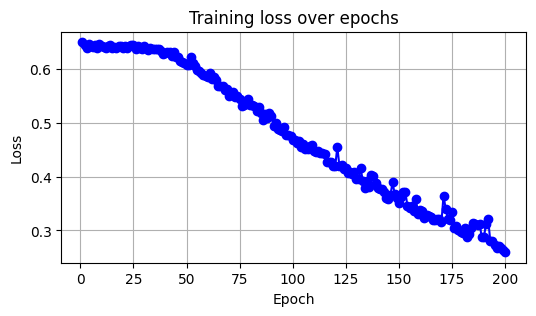

In [15]:
epochs = list(range(1, len(losses) + 1))

# Visualize the loss values
plt.figure(figsize=(6, 3))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Training loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Confusion Matrix

To evaluate the model's performance

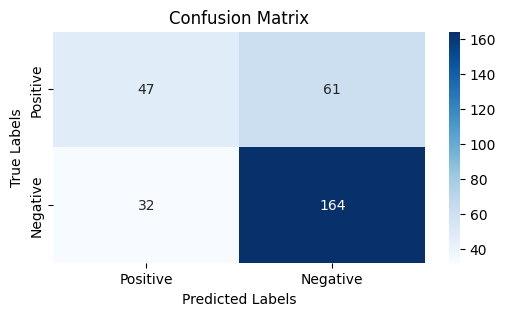

In [16]:
# Confusion matrix
import seaborn as sns

true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

for true, predicted in zip(actual_labels, predicted_labels):
    if predicted == 1 and true == 1:
        true_positives += 1
    elif predicted == 1 and true == 0:
        false_positives += 1
    elif predicted == 0 and true == 0:
        true_negatives += 1
    elif predicted == 0 and true == 1:
        false_negatives += 1

conf_matrix = np.array([[true_positives, false_negatives],
                        [false_positives, true_negatives]])

cm_labels = ['Positive', 'Negative']
categories = ['Positive', 'Negative']

plt.figure(figsize=(6,3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
f1 = f1_score(actual_labels, predicted_labels)
print("F1 score:", f1)
print("Accuracy score:", accuracy)


F1 score: 0.5026737967914439
Accuracy score: 0.694078947368421


Convert patient_id to a 1D numpy array:

In [18]:
patient_id_np = np.array(patient_id)

Calculate predicted values and probabilities for the entire training dataset:

In [22]:
# Create DataLoader for the entire dataset (data_list)
data_loader = DataLoader(data_list, batch_size=32, shuffle=False)
print("Number of examples in the entire dataset:", len(data_list))

model.eval()  # Set the model to evaluation mode
actual_labels_train = []
predicted_labels_train = []
probabilities_train = []

with torch.no_grad():  # No need to compute gradients during inference
    for data in data_loader:
        out = model(data)
        pred_train = torch.round(torch.sigmoid(out))  # Apply Sigmoid and threshold to get binary predictions
        probs_train = torch.sigmoid(out)              # Get raw probabilities
        actual_labels_train.extend(data.y.int().tolist())  # Store true labels
        predicted_labels_train.extend(pred_train.tolist())      # Store predicted labels
        probabilities_train.extend(probs_train.cpu().tolist())  # Store raw probabilities



Number of examples in the entire dataset: 1213


Check accuracy of the prediction on the entire training dataset

In [23]:
accuracy = sum(1 for a, p in zip(actual_labels_train, predicted_labels_train) if a == p) / len(actual_labels_train)
print(f'Accuracy on training data: {accuracy:.4f}')

f1 = f1_score(actual_labels_train, predicted_labels_train, average='weighted')
print(f'Weighted F1 Score on the entire training dataset: {f1:.4f}')

Accuracy on training data: 0.8714
Weighted F1 Score on the entire training dataset: 0.8692


Include sex predictins and probabilities on the trainig dataset in a pandas dataframe and save to a csv file.

In [40]:
train_pred_prob_df = pd.DataFrame({
    'participant_id': patient_id,
    'predicted_label': predicted_labels_train,
    'probability': probabilities_train
})

train_pred_prob_df.to_csv("/content/drive/MyDrive/WIDS_2025/Output/gnn_train_pred_prob_sex.csv", index=False)

## Prediction on the test set

In [28]:
def load_connectomes_test(df_conn):

    """
    Load brain connectome data, returning symmetric matrices with ones on the diagonal.
    """

    patient_id = gs.array(df_conn['participant_id'])
    data = gs.array(df_conn.drop('participant_id', axis=1))

    mat = SkewSymmetricMatrices(200).matrix_representation(data)
    mat = gs.eye(200) - gs.transpose(gs.tril(mat), (0, 2, 1))
    mat = 1.0 / 2.0 * (mat + gs.transpose(mat, (0, 2, 1)))

    return mat, patient_id

In [29]:
data_test, patient_id_test = load_connectomes_test(df_conn_test)

In [ ]:
data_test.shape

Convert data_test to tensor

In [32]:
# Convert to tensor if not already
connectivity_matrices_test = torch.tensor(data_test).float()

data_test_list = []
for i in range(len(connectivity_matrices_test)):
    matrix = connectivity_matrices_test[i]
    edge_index = (matrix > 0).nonzero(as_tuple=False).t()  # Edges where weight > 0
    edge_attr = matrix[edge_index[0], edge_index[1]]
    x = torch.eye(200)  # Identity matrix as node features

    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data_test_list.append(graph_data)

Load test data

In [36]:
# Create DataLoader for the test dataset
test_loader = DataLoader(data_test_list, batch_size=32, shuffle=False)

model.eval()
predicted_labels_test = []
probabilities_test = []

with torch.no_grad():
    for data in test_loader:
        out = model(data)
        probs_test = torch.sigmoid(out)                      # Get probabilities
        pred_test = torch.round(probs_test)                       # Get binary predictions
        predicted_labels_test.extend(pred_test.cpu().tolist())    # Move to CPU and store
        probabilities_test.extend(probs_test.cpu().tolist())

Convert patient_id, predicted labels and probabilities to numpy array before incuding in pandas dataframe

In [37]:
patient_id_test = np.array(patient_id_test)
predicted_labels_test = np.array(predicted_labels_test)
probabilities_test = np.array(probabilities_test)

Include sex preditions and probabilities on the test dataset to a pandas dataframe and save to a csv file.

In [38]:
test_pred_prob_sex_df = pd.DataFrame({
    'participant_id': patient_id_test,
    'predicted_label': predicted_labels_test,
    'probability': probabilities_test
})

test_pred_prob_sex_df.to_csv("/content/drive/MyDrive/WIDS_2025/Output/gnn_test_pred_prob_sex.csv", index=False)

Include sex preditions on the test dataset to a pandas dataframe and save to a submission csv file.

In [39]:
submission_gnn_sex = pd.DataFrame({
    'participant_id': patient_id_test,
    'predicted_label': predicted_labels_test
})

submission_gnn_sex.to_csv("/content/drive/MyDrive/WIDS_2025/Output/submission_gnn_sex.csv", index=False)